In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_features_1024_10c')
    train_ylabel = load('trainY_1024_10c')
    # 验证集
    val_xdata = load('val_features_1024_10c')
    val_ylabel = load('valY_1024_10c')
    # 测试集
    test_xdata = load('test_features_1024_10c')
    test_ylabel = load('testY_1024_10c')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

In [2]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

50
14
7


In [3]:
import torch
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(CrossAttention, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.value_dim = value_dim
        
        self.query_linear = nn.Linear(query_dim, query_dim)
        self.key_linear = nn.Linear(key_dim, query_dim)
        self.value_linear = nn.Linear(value_dim, query_dim)

    def forward(self, query, key, value):
        # 计算查询序列的注意力权重
        query_emb = self.query_linear(query)
        key_emb = self.key_linear(key)
        attention_weights = torch.bmm(query_emb, key_emb.transpose(1, 2))
        attention_weights = torch.softmax(attention_weights, dim=-1)
       
        # 根据注意力权重对值序列进行加权求和
        value_emb = self.value_linear(value)
        attended_values = torch.bmm(attention_weights, value_emb)

        return attended_values


In [4]:
# SE通道注意力机制模块
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


In [5]:
class DepthwiseSeparableConv1dSE(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1):
        super(DepthwiseSeparableConv1dSE, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1, stride=1, padding=0)
        self.se = SELayer(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.se(x)
        return x

In [6]:
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
class CNNTransformerCrossAttModel(nn.Module):
    def __init__(self, batch_size, input_dim, conv_archs, output_dim, time_input_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.5):
        """
        分类任务  params:
        batch_size          : 批次量大小
        input_dim           : 输入维度数， 特征数量
        conv_archs          : cnn 网络结构
        output_dim          : 输出的维度,类别数
        time_input_dim      : Transformer 的输入 时间序列数据维度
        hidden_dim          : 注意力维度
        num_layers          : Transformer编码器层数
        num_heads           : 多头注意力头数
        dropout_rate        : 随机丢弃神经元的概率
        """
        super().__init__()
        # 批次量大小
        self.batch_size = batch_size
        # cnn参数
        self.conv_arch = conv_archs  # 网络结构
        self.input_channels = input_dim  # 输入通道数
        self.spacefeatures = self.make_layers()

        # Transformer编码器
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.timetransformer = TransformerEncoder(
            TransformerEncoderLayer(time_input_dim, num_heads, hidden_dim, dropout=dropout_rate, batch_first=True),
            num_layers
        )

        # 交叉注意力模块
        self.cross_attention = CrossAttention(conv_archs[-1][-1], time_input_dim, time_input_dim)
       
        # 自适应平均池化
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # 定义全连接层
        self.classifier = nn.Linear(conv_archs[-1][-1] , output_dim)
     
     
    
   # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(DepthwiseSeparableConv1dSE(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    
    def forward(self, input_seq): 
        # 空间特征 卷积池化处理
        # CNN 1d卷积 网络输入 [batch,H_in, seq_length]
        space_features = self.spacefeatures(input_seq) 
        # print(time_features.size())   # torch.Size([32, 128, 128])
        # 调换维度[B, D, L] --> [B, L, D]
        space_features = space_features.permute(0,2,1)  # torch.Size([32, 128, 128])

        # 时域特征 送入Time-Transformer
        # 数据预处理
        # 注意：这里是 把数据进行了堆叠 把一个5*1024 的矩阵 进行 划分堆叠成形状为 40 * 128， 就使输入序列的长度降下来了
        input_seq = input_seq.view(self.batch_size, -1, 128) # torch.Size([32, 40, 128])
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        # 调换维度[B, D, L] --> [B, L, D]
        input_seq = input_seq.permute(0,2,1) # torch.Size([32, 128, 40])
        time_features = self.timetransformer(input_seq)  # torch.Size([32, 128, 40])
      
        # 注意力融合
        # 交叉注意力机制 cross_attention
        query = space_features
        key = time_features
        value = time_features
        cross_attention_features = self.cross_attention(query, key, value)   # torch.Size([32, 128, 128])
        # print(cross_attention_features.size())   # torch.Size([32, 128, 128])

        # 自适应平均池化
        x = self.adaptive_pool(cross_attention_features.transpose(1, 2))  # torch.Size([32, 128, 1])
        # print(x.size()) # torch.Size([32, 128, 1])
        flat_tensor = x.reshape(self.batch_size, -1)
        outputs = self.classifier(flat_tensor) # torch.Size([32, 10] 
        return outputs

In [7]:
# 定义 CNNTransformerCrossAttModel 模型参数
batch_size = 32
input_dim = 5  # 输入 5 个特征

# 空间 CNN 卷积参数
spaceconv_arch =  ((1, 32), (3, 64), (3, 128))  # CNN 层卷积池化结构  类似VGG
# Transformer参数
time_input_dim = 40  # 把一个5*1024 的矩阵 进行 划分堆叠成形状为 40 * 128， 就使输入序列的长度降下来了  时间输入就是 40维度
spaceinput_dim = 64  # 频域卷积输入维度
hidden_dim = 128  # 注意力维度
num_layers = 2   # 编码器层数
num_heads = 2   # 多头注意力头数

output_dim  = 10  # 输出维度 十分类

model = CNNTransformerCrossAttModel(batch_size, input_dim, spaceconv_arch, output_dim, time_input_dim,  hidden_dim, num_layers, num_heads)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    15
     5
   160
    32
    64
    64
    96
    32
  2048
    64
   256
   256
   192
    64
  4096
    64
   256
   256
   192
    64
  4096
    64
   256
   256
   192
    64
  8192
   128
  1024
  1024
   384
   128
 16384
   128
  1024
  1024
   384
   128
 16384
   128
  1024
  1024
  4800
   120
  1600
    40
  5120
   128
  5120
    40
    40
    40
    40
    40
  4800
   120
  1600
    40
  5120
   128
  5120
    40
    40
    40
    40
    40
 16384
   128
  5120
   128
  5120
   128
  1280
    10
______
124270


In [8]:
print(model)

CNNTransformerCrossAttModel(
  (spacefeatures): Sequential(
    (0): DepthwiseSeparableConv1dSE(
      (depthwise): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,), groups=5)
      (pointwise): Conv1d(5, 32, kernel_size=(1,), stride=(1,))
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=2, out_features=32, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): DepthwiseSeparableConv1dSE(
      (depthwise): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32)
      (pointwise): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features

Epoch:  1 train_Loss: 2.06641232 train_Accuracy:0.3613
Epoch:  1 val_Loss:1.69381871,  validate_Acc:0.5737
Epoch:  2 train_Loss: 1.38720222 train_Accuracy:0.5975
Epoch:  2 val_Loss:1.06728976,  validate_Acc:0.6942
Epoch:  3 train_Loss: 0.91843374 train_Accuracy:0.7188
Epoch:  3 val_Loss:0.73379668,  validate_Acc:0.8080
Epoch:  4 train_Loss: 0.63421086 train_Accuracy:0.8506
Epoch:  4 val_Loss:0.49370906,  validate_Acc:0.9085
Epoch:  5 train_Loss: 0.41311899 train_Accuracy:0.9237
Epoch:  5 val_Loss:0.31456072,  validate_Acc:0.9487
Epoch:  6 train_Loss: 0.27372335 train_Accuracy:0.9481
Epoch:  6 val_Loss:0.21018019,  validate_Acc:0.9754
Epoch:  7 train_Loss: 0.18772317 train_Accuracy:0.9725
Epoch:  7 val_Loss:0.15274466,  validate_Acc:0.9688
Epoch:  8 train_Loss: 0.13724289 train_Accuracy:0.9775
Epoch:  8 val_Loss:0.10394361,  validate_Acc:0.9933
Epoch:  9 train_Loss: 0.09300082 train_Accuracy:0.9906
Epoch:  9 val_Loss:0.07901819,  validate_Acc:0.9955
Epoch: 10 train_Loss: 0.08033837 trai

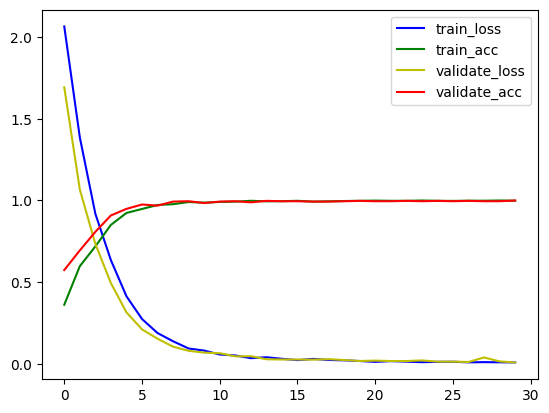

best_accuracy : 1.0


In [9]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数
    
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn_transformer_catt.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_transformer_catt3ORI.pt')
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)


# batch_size = 32
epochs = 30
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [10]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_transformer_catt3ORI.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        27
           1     1.0000    1.0000    1.0000        23
           2     0.9600    1.0000    0.9796        24
           3     1.0000    1.0000    1.0000        24
           4     1.0000    1.0000    1.0000        21
           5     1.0000    0.9474    0.9730        19
           6     1.0000    1.0000    1.0000        16
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        31
           9     1.0000    1.0000    1.0000        18

    accuracy                         0.9955       224
   macro avg     0.9960    0.9947    0.9953       224
weighted avg     0.9957    0.9955    0.9955       224



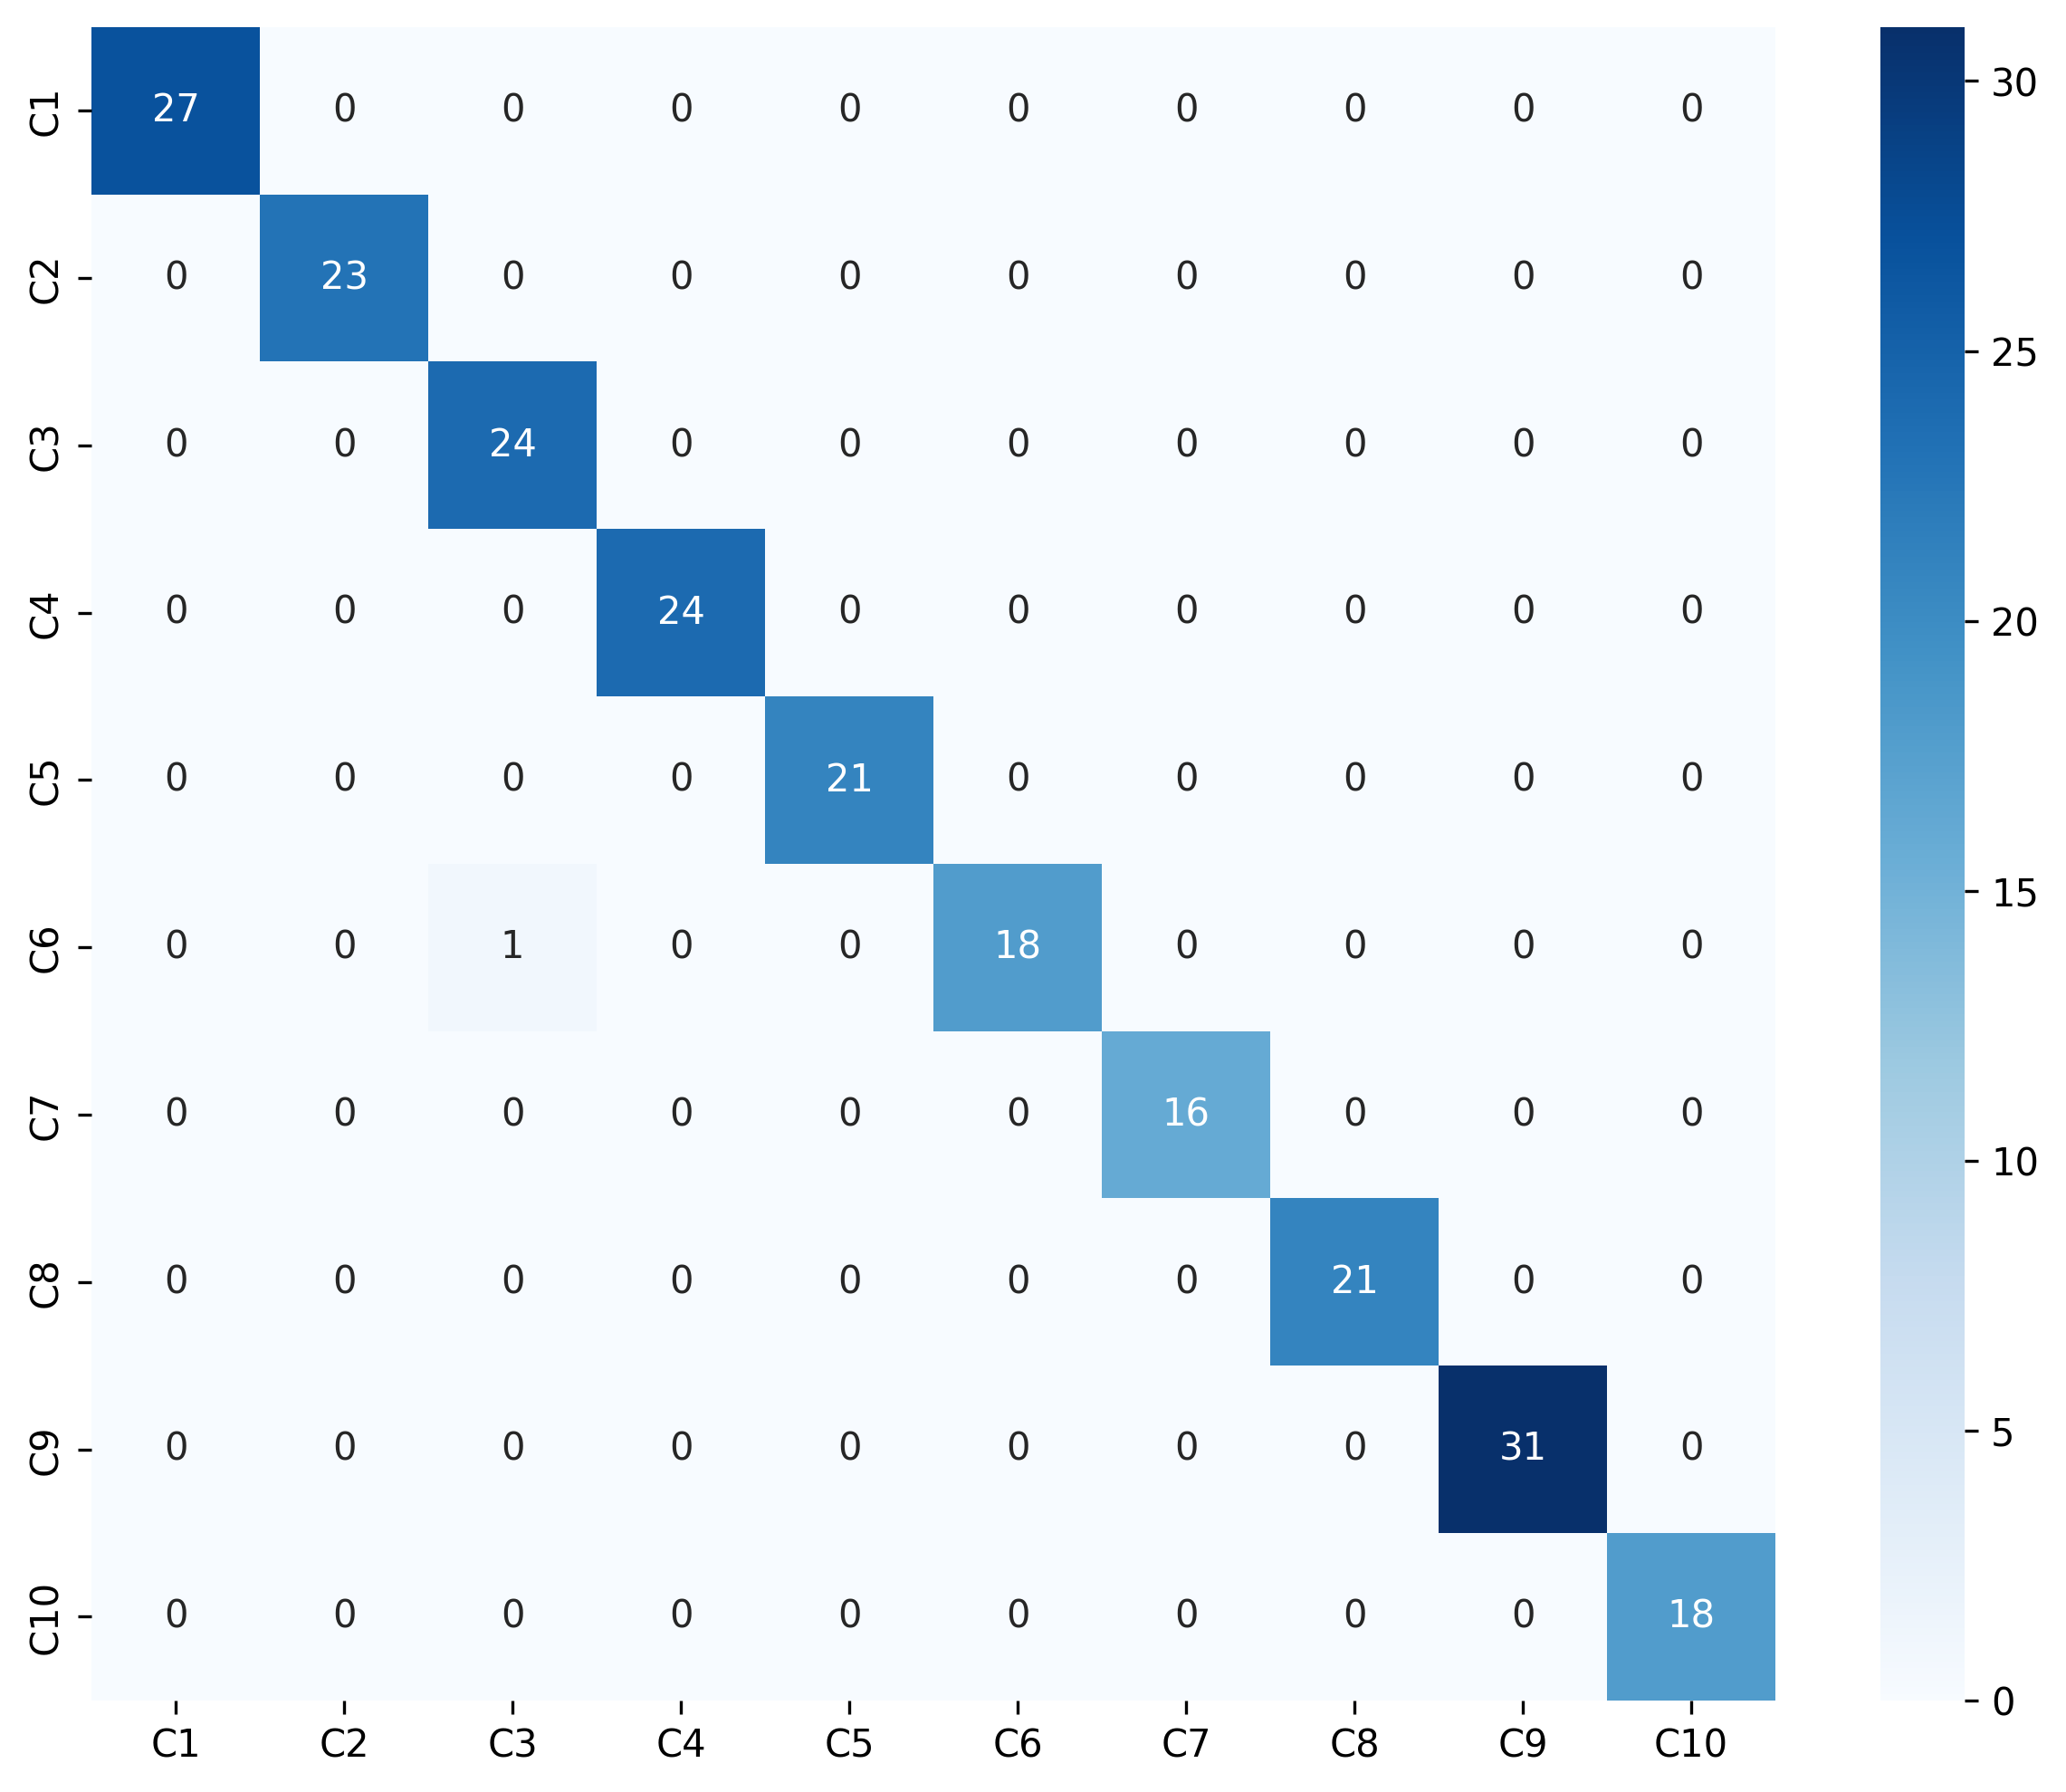

In [11]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()